<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title"><b>Modeling Linear Regression by ILP</b></span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://mate.unipv.it/gualandi" property="cc:attributionName" rel="cc:attributionURL">Stefano Gualandi</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Based on a project at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/mathcoding/opt4ds" rel="dct:source">https://github.com/mathcoding/opt4ds</a>.

# Linear Regression by Integer Linear Programming
In this notebook, we show how to find a LP model to perform linear regression. This is intended to be a modeling exercise from an optimization persepctive.

The basic example of fitting a noisy $sin(x)$ function is freely inspired from Chapter 1 of [Deep Learning, Foundations and Concepts](https://link.springer.com/book/10.1007/978-3-031-45468-4) by [C.M. Bishop](https://scholar.google.co.uk/citations?user=gsr-K3ADUvAC&hl=en&oi=ao) and [H. Bishop](https://www.linkedin.com/in/hugh-bishop-119075154).

### 3.1 Introduction to linear regression
The goal of linear regression is to predict a value $\hat{y} \in \mathbb{R}$ corresponding to an input vector $\hat{\bm{x}} \in \mathbb{R}^m$ by using a linear **Machine Learning (LM)** model. The linear ML model can be any function $f_w : \mathbb{R}^m \rightarrow \mathbb{R}$ that is linear in its parameter vector $w \in \mathbb{R}^{m+1}$. 

The **training** of the linear ML model consists in fitting the parametric function $f_w$ to a given set of $n$ samples points $(\bm{x}_1, y_1), \dots, (\bm{x}_n, y_n)$. We start in this notebook by considering the problem of fitting the noisy function $f : \mathbb{R} \rightarrow \mathbb{R}$ equal to

$$
    y = f(x) = \sin(x) + \mathcal{N}(0, 0.1)
$$

where $\mathcal{N}(0, 0.1)$ is an additive Gaussian noise.

Your task is to **train/fitting** a polynomial of degree $q$ to a given set of $n$ random samples on this noisy function. Your linear ML model is hence the following:

$$
    \hat{y} = f_w(x) = \sum_{i=0}^q w_i x^i = w_0 + w_1 x + \dots + w_q x^q 
$$

Note that this model is linear in the parameters $\bm{w} \in \mathbb{R}^{q+1}$, but it is not linear in its input data $x$.

Given a vector $\bar{\bm{w}} \in \mathbb{R}^{q+1}$, we can measure the error of the corresponding polynomial by computing the $p$ norm:

$$
    E(\bar{\bm{w}}) = || f_{\bar{\bm{w}}}(\bm{x}) - \bm{y} ||_p
$$

A common choice is to measure the error with a Root Mean Square (RMS) error:

$$
    E_{RMS}(\bar{\bm{w}}) = \sqrt{\frac{1}{n}\sum_{i=1}^n | f_{\bar{\bm{w}}}(\bm{x}_i) - \bm{y}_i |^2}
$$

Finally, since by fitting a model our main task is to **generalize** a function of the observed sample data, we are interested in the error on a set of $t$ **testing** sample points that are not used during fitting of the polynomial: the best ML model will obtain smaller errors on the testing sample points.

For this reason, we distinguish between **training** errors and **testing** errors.

**EXERCISE 1:** You have to write an Integer Linear Programming (ILP) model that find the coefficient of the polynomial of order $q$ that generalize better the given sample of points. You can use any ILP model of your choice, and the objective is to get the lowest error on a testing set.

**REMARK:** The model can be even a simple Linear Programming (LP) model, without integer variables.

Below you will find some helper functions to generate the data, plotting the functions, and measuring the errors.

### 3.2 Generate and plotting the training data
We start by writing a function generating $n$ random sample points in $[0, 2 \pi]$, with a Gaussian noise with zero mean and stdev of 0.1.
Note that we set the seed for reproducibility.

Read the official documentation of the mean [numpy](https://numpy.org/) functions used: [uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html), [normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html), and [np.sin](https://numpy.org/doc/stable/reference/generated/numpy.sin.html).

In [2]:
import numpy as np
from math import pi
from numpy.random import uniform, normal

# Generate a set of sample points with white noise
# N=Number of sample points
def GenerateSample(n=25, stdev=0.1, seed=13):
    np.random.seed(seed)
    Xs = uniform(0, 2*pi, n)   
    # Samples with white noise
    Ys = np.sin(Xs) + normal(0.0, stdev, n)
    return Xs, Ys

You can test the function with the following commands.

In [3]:
Xs, Ys = GenerateSample(n=9)
print(Xs[:3])
print(Ys[:3])

[4.88644836 1.4925155  5.17909477]
[-1.01629879  0.98259863 -0.92836675]


To plot the generating noisy function over the sample points with can use the following plotting function.

Read the official documentation of the main functions: [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html), [plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html), and [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html).

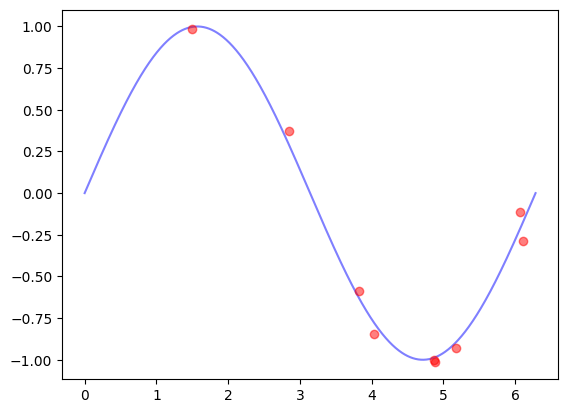

In [4]:
from matplotlib import pyplot as plt

def PlotSinSamples(Xs, Ys):
    # Plot True sin function
    D = np.linspace(0, 2*pi, 1000)
    plt.plot(D, np.sin(D), color='blue', alpha=0.5)
    # Plot sample points
    plt.plot(Xs, Ys, 'o', color='red', alpha=0.5)
    plt.show()

PlotSinSamples(Xs, Ys)

### 3.3 The fitted model is a python function
Once you find the values for a vector $\bm{w} \in \mathbb{R}^{q+1}$, your linear LM model (note that this is different from the LP model you use to find $\bm{w}$), your parametric learned function can be coded with the following python function:

In [5]:
def MakeFunction(Ws):
    def f_w(x):
        return sum(w*(x**j) for j, w in enumerate(Ws))
    return f_w

In [24]:
# Basic line for the origin: y = x
F_w = MakeFunction([0, 1/4, 0])
print(F_w(4), F_w(3))

1.0 0.75


To plot the predict values by your function $F$ over the domain $[0, 2\pi]$, you can use the following plot function:

In [25]:

def PlotPolynomial(Xs, Ys, F):
    # Plot True sin function
    D = np.linspace(0, 2*pi, 1000)
    plt.plot(D, np.sin(D), color='blue', alpha=0.5)
    # Plot sample points
    plt.plot(D, [F(x) for x in D], color='green', alpha=0.3)
    # Plot sample points
    plt.plot(Xs, Ys, 'o', color='red', alpha=0.5)
    plt.plot(Xs, [F(x) for x in Xs], 'o', color='green', alpha=0.3)

    plt.axis([0, 2*pi, -1.5, +1.5])

    plt.show()

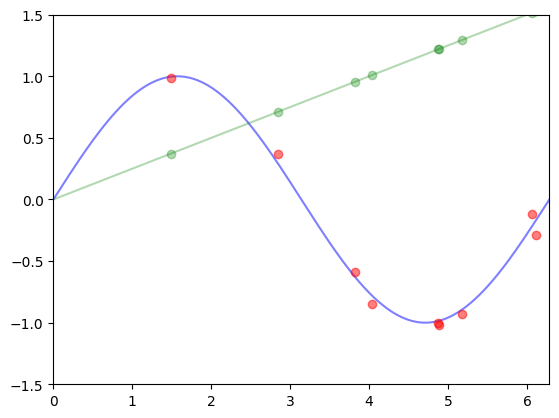

In [26]:
PlotPolynomial(Xs, Ys, F_w)

### 3.4 Error evaluation
Once you have trained your linear model (that is, you have found a vector $\bm{w} \in \mathbb{R}^{q+1}$), you have to evaluate how your model has generalized over the training data.

For this reason, first you have to sample a new set of testing point:

In [9]:
# Testing data
Xtest, Ytest = GenerateSample(n=50, seed=17)

Then, you have to evaluate your model over the test set using the RMS error function:

In [10]:
def RMS(Xs, Ys, F):
    return np.sqrt(sum((F(x) - y)**2 for x, y in zip(Xs, Ys)) / len(Xs))

In [11]:
print('Current model, trainig RMS:', round(RMS(Xs, Ys, F_w), 4))
print('Current model, testing RMS:', round(RMS(Xtest, Ytest, F_w), 4))


Current model, trainig RMS: 1.7362
Current model, testing RMS: 1.4092


### 3.5 Write an LP model to fit the polynomial coefficients
Now, you have to write and solve an ILP model that find the best value for $\bar{w}$, and return a prediction function, that given $\bm{x}$ return a predicted target value $\hat{y}$, using the previous `MakeFunction(Ws)`.

In [ ]:
# Run if on Colab
# %pip install gurobipy

In [ ]:
from gurobipy import Model, GRB, quicksum, Env

def FittingByLP(Xs, Ys, q):
    # LP model        
    env = Env(params={'OutputFlag': 0})
    model = Model(env=env)
    
    # Add variables
    w = [model.addVar(lb=-GRB.INFINITY) for _ in range(q+1)]
    # TODO....

    # Add constraints
    # TODO....
    
    model.optimize()
    
    # TODO: add solver status check

    # Return the prediction function
    return MakeFunction([w[i].X for i in range(q+1)])


In [ ]:
F_LP = FittingByLP(Xs, Ys, 3)

print('Current model, trainig RMS:', round(RMS(Xs, Ys, F_LP), 4))
print('Current model, testing RMS:', round(RMS(Xtest, Ytest, F_LP), 4))

In [ ]:
PlotPolynomial(Xs, Ys, F_LP)

Once you have found your model, you should run experiments to study the trade off between the complexity of your model (i.e., tha maximum degree of the polynoial), the number of samples points (i.e., the size of your training dataset), and the different choices of your ILP model.

In [ ]:
# Check the complexity of the model
def CheckComplexity(n=9, seed=13):
    # Generate training data
    Xs, Ys = GenerateSample(n, seed=seed)
    Xt, Yt = GenerateSample(2*n, seed=seed)

    for q in range(9):
        F = FittingByLP(Xs, Ys, q)
        if F is None:
            print('ERROR: model was not fittted')
        else:
            print('q={}, Training size: {}, RMS: {}'.format(q, n, round(RMS(Xs, Ys, F), 4)))
            print('q={}, Testing  size: {}, RMS: {}'.format(q, 2*n, round(RMS(Xt, Yt, F), 4)))
            print()

CheckComplexity()

In [ ]:
# Check the complexity of the model
def PlotComplexity(n=9, seed=13):
    # Generate training data
    Xs, Ys = GenerateSample(n, seed=seed)
    Xt, Yt = GenerateSample(2*n, seed=seed)

    TrainRMS = []
    TestRMS = []
    for q in range(9):
        F = FittingByLP(Xs, Ys, q)
        TrainRMS.append(RMS(Xs, Ys, F))
        TestRMS.append(RMS(Xt, Yt, F))
    
    plt.plot(TrainRMS, label='Training', color='red')
    plt.plot(TestRMS, label='Testing', color='blue')
    plt.xlabel('Model complexity')
    plt.ylabel('RMS')
    plt.title('ML Model complexity vs RMS with {} sample points'.format(n))
    plt.legend()
    plt.show()

PlotComplexity(100)

### 3.6 CHALLENGE: Predicting diabete
In this challenge, you have to use a linear LM model to predict a target value that is a measure of disease (diabete) progression using 10 measurements. The [diabete dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html) is a standard dataset for linear regression and is available on the [sklearn](https://scikit-learn.org/) library.

The following steps show how to import and set this dataset.

In [ ]:
from sklearn.datasets import load_diabetes

rawdata = load_diabetes()

print([k for k in rawdata])

In [ ]:
# First 5 target values
rawdata.target[:5]

In [ ]:
# First 5 input vectors
print(rawdata.data[:5])

In [ ]:
# To set your data set
Xs = rawdata.data
Ys = rawdata.target

# To split the train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.2, random_state=13)


Please, check the documentation of the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function.

You the test data for training your model, and the test data for validation.

**ASSIGNMENT:** You have to fill the following function with the best ILP model to fit a linear regression model using Gurobi. The fit function must return a predict function, similarly to the function used to fit a polynomial.

In [ ]:
def FittingDiabete(Xs, Ys):
    # LP model        
    env = Env(params={'OutputFlag': 0})
    model = Model(env=env)
    
    # Add variables

    # TODO: Complete with your LP model
    # ....

    
    # Return the prediction function
    def F(x):
        # IMPLEMENT YOUR FITTING FUNCION, USING THE ILP SOLUTION
        return 0
    return F

Work in team of maximum 3 students, and return your solution (the fitting function) by email before April 3rd, at midnight.

### 3.7 CHALLENGE: Predict insurance costs
In this challenge, you have to use a linear LM model to predict the insurance costs (i.e., *charges*) by using a vector 6 elements.

For the training you can use the *insurance_train.csv* file. For the evaluation, we will use an hidden test file.

In [ ]:
# Uncomment and execute the following to get the data
# !wget https://raw.githubusercontent.com/mathcoding/opt4ds/master/data/insurance_train.csv

In [ ]:
import csv
with open('../data/insurance_train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    Xs = []
    Ys = []
    for row in spamreader:
        if row[0] != 'age':
            line = list(map(lambda s: float(s.replace(',','.')), row))
            Xs.append(line[:-1])
            Ys.append(line[-1])  

# If you prefer to work with numpy arrays
import numpy as np
Xs = np.matrix(Xs)
Ys = np.array(Ys)
print(Xs[:3])
print(Ys[:3])

Work in team of maximum 3 students, and return your solution (the fitting function) by email before April 3rd, at midnight.